# Original code

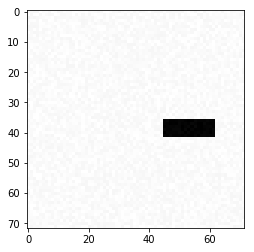

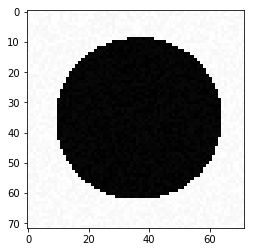

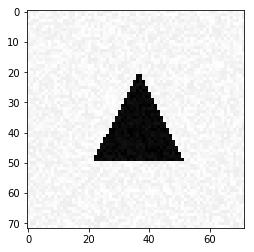

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(72,72), cmap='gray')
plt.show()

im = generate_a_disk(10)
plt.imshow(im.reshape(72,72), cmap='gray')
plt.show()

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(72,72), cmap='gray')
plt.show()


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((72,72))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]




# 2. Simple classification

## Generate dataset classification

In [3]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
100
200


1.0


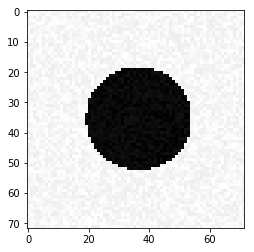

In [4]:
X_train.shape
plt.imshow(X_train[0].reshape(72,72),cmap='gray')
print(Y_train[0])

## Training the network

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, add
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras import initializers
from keras import regularizers
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Using TensorFlow backend.


### SGD optimization

#### Train

In [6]:
modelSGD = Sequential()
nb_neurons = 20
modelSGD.add(Dense(nb_neurons, input_shape=(X_train.shape[1],))) 
modelSGD.add(Activation('relu'))
modelSGD.add(Dense(3))
modelSGD.add(Activation('softmax'))

sgd = SGD(lr=0.002, decay=1e-6, momentum=0.0,  nesterov=True) 
modelSGD.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy']) 
y_train = np_utils.to_categorical(Y_train, 3) 
modelSGD.fit(X_train, y_train, epochs=100, batch_size=32) 


Epoch 1/100
300/300 [==============================] - 12s 40ms/step - loss: 1.1406 - acc: 0.4167
Epoch 2/100
300/300 [==============================] - 0s 144us/step - loss: 0.9677 - acc: 0.5333
Epoch 3/100
300/300 [==============================] - 0s 148us/step - loss: 0.8892 - acc: 0.6333
Epoch 4/100
300/300 [==============================] - 0s 244us/step - loss: 0.9662 - acc: 0.5467
Epoch 5/100
300/300 [==============================] - 0s 163us/step - loss: 0.8465 - acc: 0.6800
Epoch 6/100
300/300 [==============================] - 0s 143us/step - loss: 0.7685 - acc: 0.7133
Epoch 7/100
300/300 [==============================] - 0s 134us/step - loss: 0.7197 - acc: 0.7133
Epoch 8/100
300/300 [==============================] - 0s 141us/step - loss: 0.6586 - acc: 0.7467
Epoch 9/100
300/300 [==============================] - 0s 145us/step - loss: 0.6731 - acc: 0.7233
Epoch 10/100
300/300 [==============================] - 0s 145us/step - loss: 0.7057 - acc: 0.6633
Epoch 11/100
300/30

#### Test

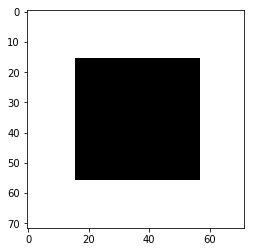

array([[ 1.,  0.,  0.]], dtype=float32)

In [7]:
X_test = generate_a_rectangle()
plt.imshow(X_test.reshape(72,72),cmap="gray")
plt.show()
X_test = X_test.reshape(1, X_test.shape[0])
modelSGD.predict(X_test)

### Adam optimization

In [8]:
modelAdam = Sequential()
nb_neurons = 20
modelAdam.add(Dense(nb_neurons, input_shape=(X_train.shape[1],)))
modelAdam.add(Activation('relu'))
modelAdam.add(Dense(3))
modelAdam.add(Activation('softmax'))

#X_train /= 255
modelAdam.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
y_train = np_utils.to_categorical(Y_train,3)
modelAdam.fit(X_train, y_train, epochs=100, batch_size=32) 

Epoch 1/100
300/300 [==============================] - 0s 1ms/step - loss: 1.7749 - acc: 0.3800
Epoch 2/100
300/300 [==============================] - 0s 163us/step - loss: 1.1266 - acc: 0.4667
Epoch 3/100
300/300 [==============================] - 0s 183us/step - loss: 0.9276 - acc: 0.5367
Epoch 4/100
300/300 [==============================] - 0s 194us/step - loss: 0.8342 - acc: 0.5933
Epoch 5/100
300/300 [==============================] - 0s 194us/step - loss: 0.7369 - acc: 0.6633
Epoch 6/100
300/300 [==============================] - 0s 184us/step - loss: 0.6693 - acc: 0.7400
Epoch 7/100
300/300 [==============================] - 0s 191us/step - loss: 0.6234 - acc: 0.8133
Epoch 8/100
300/300 [==============================] - 0s 175us/step - loss: 0.6005 - acc: 0.7767
Epoch 9/100
300/300 [==============================] - 0s 196us/step - loss: 0.5404 - acc: 0.8400
Epoch 10/100
300/300 [==============================] - 0s 185us/step - loss: 0.4993 - acc: 0.8767
Epoch 11/100
300/300 

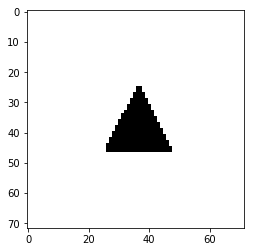

array([[ 0.,  0.,  1.]], dtype=float32)

In [9]:
X_test = generate_a_rectangle()
[X_test,V] = generate_a_triangle()
#X_test /= 255
plt.imshow(X_test.reshape(72,72),cmap="gray")
plt.show()
X_test = X_test.reshape(1, X_test.shape[0])
modelAdam.predict(X_test)

## 3. Visualization

In [10]:
a = modelSGD.get_weights()
b = modelAdam.get_weights()

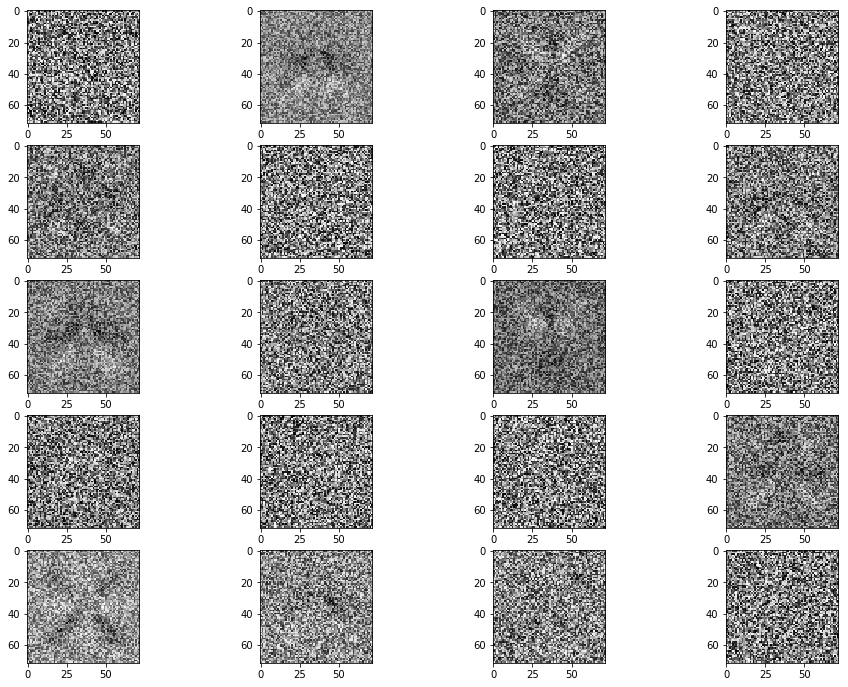

In [11]:
plt.figure(figsize=(16,12))
for i in range(nb_neurons):    
    plt.subplot(5,4,1+i)
    plt.imshow(a[0][:,i].reshape(72,72),cmap="gray")
plt.show()

##  4. A More Difficult Classification Problem

### Generate training data with jitter

In [12]:
[X_train, Y_train] = generate_dataset_classification(500, 20, True)

Creating data:
0
100
200
300
400


### Generate testing data

In [14]:
[X_test, Y_test] = generate_test_set_classification()
print(Y_test.shape)

Creating data:
0
100
200
(300, 3)


### Retrain on the new data

#### SGD

In [13]:
modelSGD = Sequential()
nb_neurons = 20 
modelSGD.add(Dense(nb_neurons, input_shape=(X_train.shape[1],),kernel_regularizer=regularizers.l2(0.001))) 
modelSGD.add(Activation('sigmoid'))
modelSGD.add(Dense(3))
modelSGD.add(Activation('softmax'))

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.03,  nesterov=True) 
modelSGD.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=['accuracy']) 
y_train = np_utils.to_categorical(Y_train, 3) 
modelSGD.fit(X_train, y_train, epochs=200, batch_size=32) 

Epoch 1/200
500/500 [==============================] - 0s 893us/step - loss: 1.1456 - acc: 0.3600
Epoch 2/200
500/500 [==============================] - 0s 201us/step - loss: 1.1229 - acc: 0.4000
Epoch 3/200
500/500 [==============================] - 0s 172us/step - loss: 1.1056 - acc: 0.4320
Epoch 4/200
500/500 [==============================] - 0s 148us/step - loss: 1.0940 - acc: 0.4080
Epoch 5/200
500/500 [==============================] - 0s 171us/step - loss: 1.0887 - acc: 0.4220
Epoch 6/200
500/500 [==============================] - 0s 181us/step - loss: 1.0802 - acc: 0.4380
Epoch 7/200
500/500 [==============================] - 0s 174us/step - loss: 1.0702 - acc: 0.4580
Epoch 8/200
500/500 [==============================] - 0s 173us/step - loss: 1.0571 - acc: 0.4780
Epoch 9/200
500/500 [==============================] - 0s 169us/step - loss: 1.0485 - acc: 0.5080
Epoch 10/200
500/500 [==============================] - 0s 195us/step - loss: 1.0339 - acc: 0.5320
Epoch 11/200
500/50

500/500 [==============================] - 0s 153us/step - loss: 0.6145 - acc: 0.7500
Epoch 166/200
500/500 [==============================] - 0s 151us/step - loss: 0.6319 - acc: 0.7180
Epoch 167/200
500/500 [==============================] - 0s 157us/step - loss: 0.6130 - acc: 0.7420
Epoch 168/200
500/500 [==============================] - 0s 164us/step - loss: 0.5953 - acc: 0.7820
Epoch 169/200
500/500 [==============================] - 0s 154us/step - loss: 0.6054 - acc: 0.7240
Epoch 170/200
500/500 [==============================] - 0s 144us/step - loss: 0.6006 - acc: 0.7580
Epoch 171/200
500/500 [==============================] - 0s 158us/step - loss: 0.5989 - acc: 0.7760
Epoch 172/200
500/500 [==============================] - 0s 173us/step - loss: 0.6080 - acc: 0.7400
Epoch 173/200
500/500 [==============================] - 0s 212us/step - loss: 0.6068 - acc: 0.7520
Epoch 174/200
500/500 [==============================] - 0s 206us/step - loss: 0.6200 - acc: 0.7240
Epoch 175/200


#### Adam

In [15]:
modelAdam = Sequential()
nb_neurons = 20
modelAdam.add(Dense(nb_neurons, input_shape=(X_train.shape[1],),kernel_regularizer=regularizers.l2(0.001))) 
modelAdam.add(Activation('relu'))
modelAdam.add(Dense(3,))
modelAdam.add(Activation('softmax'))

optim = Adam(lr=0.001, 
             beta_1=0.9,
             beta_2=0.999,
             epsilon=None,
             decay=1e-6,
             amsgrad=False)

modelAdam.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy']) 
y_train = np_utils.to_categorical(Y_train,3)
modelAdam.fit(X_train, y_train, epochs=100, batch_size=32) 

Epoch 1/100
500/500 [==============================] - 0s 745us/step - loss: 1.5891 - acc: 0.3780
Epoch 2/100
500/500 [==============================] - 0s 158us/step - loss: 1.0531 - acc: 0.4540
Epoch 3/100
500/500 [==============================] - 0s 174us/step - loss: 1.0228 - acc: 0.4880
Epoch 4/100
500/500 [==============================] - 0s 161us/step - loss: 1.0258 - acc: 0.4980
Epoch 5/100
500/500 [==============================] - 0s 181us/step - loss: 0.9844 - acc: 0.5180
Epoch 6/100
500/500 [==============================] - 0s 167us/step - loss: 0.9045 - acc: 0.5340
Epoch 7/100
500/500 [==============================] - 0s 170us/step - loss: 0.8413 - acc: 0.5640
Epoch 8/100
500/500 [==============================] - 0s 173us/step - loss: 0.8463 - acc: 0.5840
Epoch 9/100
500/500 [==============================] - 0s 175us/step - loss: 0.8014 - acc: 0.6140
Epoch 10/100
500/500 [==============================] - 0s 175us/step - loss: 0.8052 - acc: 0.6040
Epoch 11/100
500/50

### Evaluate linear neural networks

#### SGD

In [16]:
modelSGD.evaluate(X_test,Y_test)

300/300 [==============================] - 0s 278us/step


[0.80328146298726399, 0.61999999960263574]

#### Adam

In [17]:
modelAdam.evaluate(X_test,Y_test)

300/300 [==============================] - 0s 250us/step


[0.81660295327504473, 0.59999999920527136]

## Build CNN

In [18]:
from keras.layers import Conv2D, MaxPooling2D 

# Reshape train and test inputs
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1) 
X_train = X_train.astype('float32')

X_test = X_test.reshape(X_test.shape[0], 72, 72, 1) 
X_test = X_test.astype('float32')

# Build layers

modelCNN = Sequential()
modelCNN.add(Conv2D(16, (5,5), activation='relu', input_shape=(72,72,1)))

print(modelCNN.output_shape)

modelCNN.add(MaxPooling2D(pool_size=(2, 2))) 
print(modelCNN.output_shape) 

from keras.layers import Dropout 
modelCNN.add(Dropout(0.25)) 
print(modelCNN.output_shape) 

from keras.layers import Flatten 
modelCNN.add(Flatten()) 
print(modelCNN.output_shape) 

modelCNN.add(Dense(128, activation='relu'))
print(modelCNN.output_shape)
             
modelCNN.add(Dropout(0.5)) 
modelCNN.add(Dense(3, activation='softmax')) 
print(modelCNN.output_shape)

(None, 68, 68, 16)
(None, 34, 34, 16)
(None, 34, 34, 16)
(None, 18496)
(None, 128)
(None, 3)


In [19]:
# Optimization

modelCNN.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [20]:
modelCNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 34, 34, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               2367616   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 387       
Total para

### Train

In [21]:
Y_train = np_utils.to_categorical(Y_train,3)
modelCNN.fit(X_train, Y_train,  batch_size=32, epochs=100, verbose=1) 


Epoch 1/100
500/500 [==============================] - 4s 8ms/step - loss: 1.2342 - acc: 0.4240
Epoch 2/100
500/500 [==============================] - 1s 1ms/step - loss: 0.8740 - acc: 0.6240
Epoch 3/100
500/500 [==============================] - 1s 1ms/step - loss: 0.7094 - acc: 0.7020
Epoch 4/100
500/500 [==============================] - 1s 1ms/step - loss: 0.6082 - acc: 0.7560
Epoch 5/100
500/500 [==============================] - 1s 1ms/step - loss: 0.5413 - acc: 0.7860
Epoch 6/100
500/500 [==============================] - 1s 1ms/step - loss: 0.4682 - acc: 0.8440
Epoch 7/100
500/500 [==============================] - 1s 1ms/step - loss: 0.4241 - acc: 0.8480
Epoch 8/100
500/500 [==============================] - 1s 1ms/step - loss: 0.3526 - acc: 0.9000
Epoch 9/100
500/500 [==============================] - 1s 1ms/step - loss: 0.3226 - acc: 0.8860
Epoch 10/100
500/500 [==============================] - 1s 1ms/step - loss: 0.2743 - acc: 0.9240
Epoch 11/100
500/500 [=================

### Testing

[[  6.42613589e-17   1.00000000e+00   8.40943088e-20]]


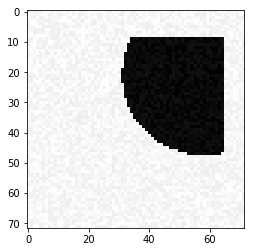

In [22]:
plt.imshow(X_test[173].reshape(72,72), cmap = 'gray') 
X_test_norm = X_test[173]
print(modelCNN.predict(X_test_norm.reshape(1, 72, 72, 1))) 

In [23]:
modelCNN.evaluate(X_test,Y_test)

300/300 [==============================] - 0s 540us/step


[0.94933440685272219, 0.83333333253860475]

In [43]:
1e+0

1.0

### Visualization

In [141]:
a = modelCNN.get_weights()

In [160]:
a[2].shape

(18496, 128)

In [161]:
b = a[2].reshape((34,34,16,128))

In [172]:
plt.imshow(b[:,:,6,32])

SyntaxError: invalid syntax (<ipython-input-172-d090483d6128>, line 1)

In [174]:
b = a[2].reshape(34,34,16,128)
c = np.sum(b,3)

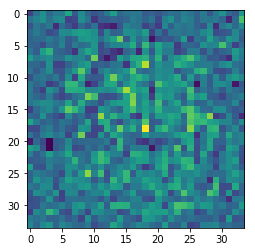

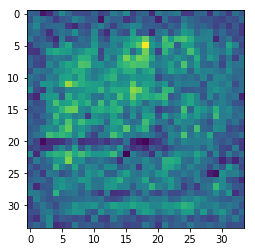

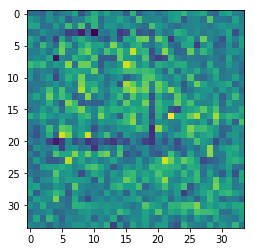

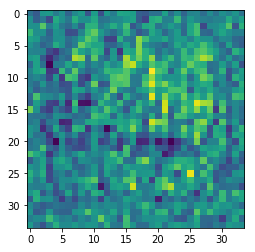

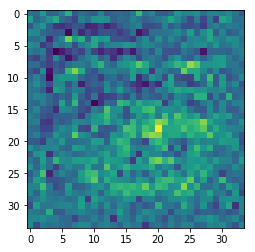

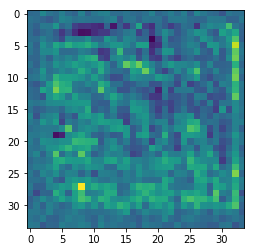

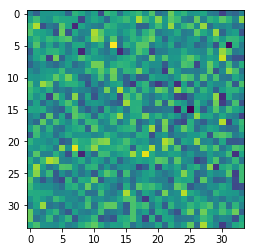

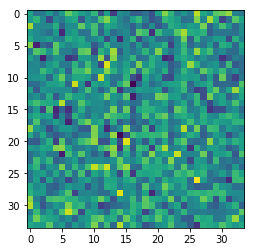

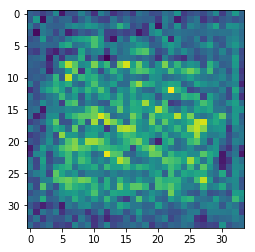

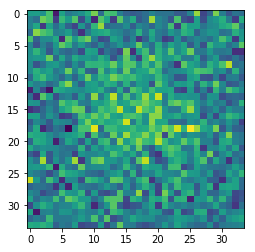

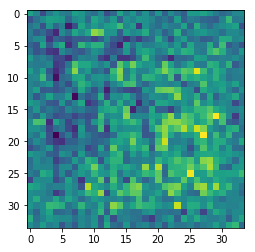

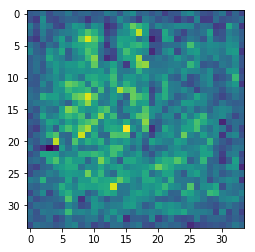

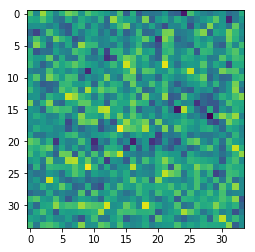

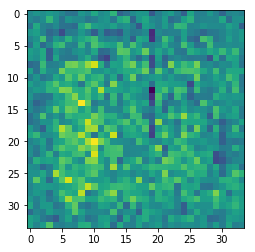

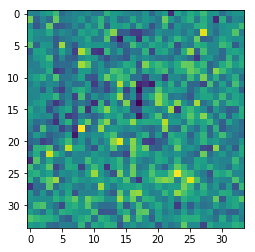

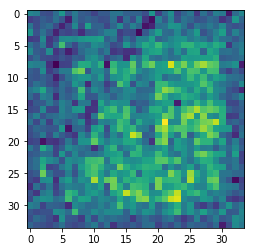

In [175]:
for i in range(16):
    plt.imshow(c[:,:,i])
    plt.show()
    


## 5. A regression problem

In [143]:
[X_train, Y_train] = generate_dataset_regression(1000, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [139]:
Y_train[0]

array([ 0.15443799,  0.22564241,  0.12332371,  0.02798616,  0.86756739,
        0.74118695])

### reorder the triangle vertices

In [144]:
for i,tr in enumerate(Y_train):
    print(tr)
    tr = tr.reshape(3,2)
    print(tr)
    x_tr = tr[:,0]
    y_tr = tr[:,1]
    
    idx = sorted(range(len(x_tr)), key=lambda k: x_tr[k])
    y_tr = [y_tr[j] for j in idx]
    x_tr = [x_tr[j] for j in idx]
        
    Y_train[i] = np.stack((x_tr,y_tr), axis=-1).reshape(6,)   
    print(Y_train[i])

[ 0.96065696  0.11172137  0.50580265  0.62857086  0.97451936  0.4946591 ]
[[ 0.96065696  0.11172137]
 [ 0.50580265  0.62857086]
 [ 0.97451936  0.4946591 ]]
[ 0.50580265  0.62857086  0.96065696  0.11172137  0.97451936  0.4946591 ]
[ 0.20755358  0.99329193  0.30601128  0.14190851  0.2487634   0.67377545]
[[ 0.20755358  0.99329193]
 [ 0.30601128  0.14190851]
 [ 0.2487634   0.67377545]]
[ 0.20755358  0.99329193  0.2487634   0.67377545  0.30601128  0.14190851]
[ 0.50045028  0.21264264  0.05824051  0.47770733  0.39501131  0.18563232]
[[ 0.50045028  0.21264264]
 [ 0.05824051  0.47770733]
 [ 0.39501131  0.18563232]]
[ 0.05824051  0.47770733  0.39501131  0.18563232  0.50045028  0.21264264]
[ 0.37040115  0.8419689   0.09694466  0.12886948  0.27887335  0.15965896]
[[ 0.37040115  0.8419689 ]
 [ 0.09694466  0.12886948]
 [ 0.27887335  0.15965896]]
[ 0.09694466  0.12886948  0.27887335  0.15965896  0.37040115  0.8419689 ]
[ 0.89578053  0.67192093  0.3154893   0.3722811   0.5630855   0.44867205]
[[ 0.8

[ 0.65790258  0.33592338  0.1322416   0.94172686  0.40196242  0.28432639]
[[ 0.65790258  0.33592338]
 [ 0.1322416   0.94172686]
 [ 0.40196242  0.28432639]]
[ 0.1322416   0.94172686  0.40196242  0.28432639  0.65790258  0.33592338]
[ 0.50050713  0.80378423  0.81622753  0.37189122  0.29921249  0.98942633]
[[ 0.50050713  0.80378423]
 [ 0.81622753  0.37189122]
 [ 0.29921249  0.98942633]]
[ 0.29921249  0.98942633  0.50050713  0.80378423  0.81622753  0.37189122]
[ 0.52753767  0.34972522  0.79684643  0.23648654  0.17541648  0.61380661]
[[ 0.52753767  0.34972522]
 [ 0.79684643  0.23648654]
 [ 0.17541648  0.61380661]]
[ 0.17541648  0.61380661  0.52753767  0.34972522  0.79684643  0.23648654]
[ 0.44146694  0.84401285  0.03869021  0.34351879  0.07607835  0.61623919]
[[ 0.44146694  0.84401285]
 [ 0.03869021  0.34351879]
 [ 0.07607835  0.61623919]]
[ 0.03869021  0.34351879  0.07607835  0.61623919  0.44146694  0.84401285]
[ 0.25648776  0.33398341  0.52618143  0.91023257  0.11113884  0.49407811]
[[ 0.2

[ 0.68321269  0.33240774  0.7188613   0.47018119  0.6664105   0.20776931]
[[ 0.68321269  0.33240774]
 [ 0.7188613   0.47018119]
 [ 0.6664105   0.20776931]]
[ 0.6664105   0.20776931  0.68321269  0.33240774  0.7188613   0.47018119]
[ 0.62158626  0.21651931  0.26856538  0.04009273  0.66225073  0.68643859]
[[ 0.62158626  0.21651931]
 [ 0.26856538  0.04009273]
 [ 0.66225073  0.68643859]]
[ 0.26856538  0.04009273  0.62158626  0.21651931  0.66225073  0.68643859]
[ 0.13035542  0.1548199   0.48880431  0.18505809  0.5700973   0.17929308]
[[ 0.13035542  0.1548199 ]
 [ 0.48880431  0.18505809]
 [ 0.5700973   0.17929308]]
[ 0.13035542  0.1548199   0.48880431  0.18505809  0.5700973   0.17929308]
[ 0.90149039  0.96017839  0.01746824  0.37025485  0.30772585  0.93279393]
[[ 0.90149039  0.96017839]
 [ 0.01746824  0.37025485]
 [ 0.30772585  0.93279393]]
[ 0.01746824  0.37025485  0.30772585  0.93279393  0.90149039  0.96017839]
[ 0.08163301  0.12307246  0.92751691  0.18974497  0.2301317   0.92686647]
[[ 0.0

 [ 0.80259421  0.68262263]]
[ 0.66799293  0.94288678  0.68927414  0.87879351  0.80259421  0.68262263]
[ 0.21922032  0.03918515  0.08539302  0.0839455   0.03752756  0.08699906]
[[ 0.21922032  0.03918515]
 [ 0.08539302  0.0839455 ]
 [ 0.03752756  0.08699906]]
[ 0.03752756  0.08699906  0.08539302  0.0839455   0.21922032  0.03918515]
[ 0.46087101  0.32010204  0.4399811   0.79926963  0.38691366  0.61074578]
[[ 0.46087101  0.32010204]
 [ 0.4399811   0.79926963]
 [ 0.38691366  0.61074578]]
[ 0.38691366  0.61074578  0.4399811   0.79926963  0.46087101  0.32010204]
[ 0.86645517  0.35869435  0.48744243  0.29331684  0.99076032  0.47151364]
[[ 0.86645517  0.35869435]
 [ 0.48744243  0.29331684]
 [ 0.99076032  0.47151364]]
[ 0.48744243  0.29331684  0.86645517  0.35869435  0.99076032  0.47151364]
[ 0.68791899  0.03854685  0.74655705  0.98139181  0.40765284  0.98857613]
[[ 0.68791899  0.03854685]
 [ 0.74655705  0.98139181]
 [ 0.40765284  0.98857613]]
[ 0.40765284  0.98857613  0.68791899  0.03854685  0.

 [ 0.90580703  0.74323398]]
[ 0.68054968  0.51814193  0.70835069  0.6720892   0.90580703  0.74323398]
[ 0.95884899  0.50676215  0.83176037  0.6749788   0.10563244  0.09215796]
[[ 0.95884899  0.50676215]
 [ 0.83176037  0.6749788 ]
 [ 0.10563244  0.09215796]]
[ 0.10563244  0.09215796  0.83176037  0.6749788   0.95884899  0.50676215]
[ 0.78980733  0.43157072  0.27242962  0.45674167  0.42225401  0.89094786]
[[ 0.78980733  0.43157072]
 [ 0.27242962  0.45674167]
 [ 0.42225401  0.89094786]]
[ 0.27242962  0.45674167  0.42225401  0.89094786  0.78980733  0.43157072]
[ 0.79420752  0.86262769  0.30772243  0.06626627  0.84044622  0.30324344]
[[ 0.79420752  0.86262769]
 [ 0.30772243  0.06626627]
 [ 0.84044622  0.30324344]]
[ 0.30772243  0.06626627  0.79420752  0.86262769  0.84044622  0.30324344]
[ 0.81367551  0.27295149  0.11071732  0.55824144  0.36073511  0.40305009]
[[ 0.81367551  0.27295149]
 [ 0.11071732  0.55824144]
 [ 0.36073511  0.40305009]]
[ 0.11071732  0.55824144  0.36073511  0.40305009  0.

In [145]:
Y_train.shape

(1000, 6)

In [146]:
mean_x = Y_train[:,[0,2,4]].mean()
mean_y = Y_train[:,[1,3,5]].mean()
std_x = Y_train[:,[0,2,4]].std()
std_y = Y_train[:,[1,3,5]].std()

In [147]:
Y_train_norm = Y_train
Y_train_norm[:,[0,2,4]] = (Y_train_norm[:,[0,2,4]] - mean_x)/std_x
Y_train_norm[:,[1,3,5]] = (Y_train_norm[:,[1,3,5]] - mean_y)/std_y

In [205]:
from keras.layers import Conv2D, MaxPooling2D 

from keras.layers import Dropout 

# Reshape train and test inputs
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1) 
X_train = X_train.astype('float32')

X_test = X_test.reshape(X_test.shape[0], 72, 72, 1) 
X_test = X_test.astype('float32')

# Build layers

modelReg = Sequential()
modelReg.add(Conv2D(16, (5,5), activation='linear', input_shape=(72,72,1)))
modelReg.add(Activation('relu'))

print(modelReg.output_shape)

modelReg.add(MaxPooling2D(pool_size=(2, 2))) 
print(modelReg.output_shape) 
#modelReg.add(Dropout(0.2))


modelReg.add(Conv2D(32, (3,3), activation='linear'))
modelReg.add(Activation('relu'))
print(modelReg.output_shape)

modelReg.add(MaxPooling2D(pool_size=(2, 2))) 
print(modelReg.output_shape) 

#modelReg.add(Dropout(0.1)) 
print(modelReg.output_shape) 

modelReg.add(Conv2D(64, (3,3), activation='linear'))
modelReg.add(Activation('relu'))

print(modelReg.output_shape)

modelReg.add(MaxPooling2D(pool_size=(2, 2))) 
print(modelReg.output_shape) 

#modelReg.add(Dropout(0.3)) 
print(modelReg.output_shape)

modelReg.add(Conv2D(128, (3,3), activation='linear'))
modelReg.add(Activation('relu'))

print(modelReg.output_shape)

modelReg.add(MaxPooling2D(pool_size=(2, 2))) 
print(modelReg.output_shape) 

#modelReg.add(Dropout(0.3)) 
print(modelReg.output_shape)

from keras.layers import Flatten 
modelReg.add(Flatten()) 
print(modelReg.output_shape) 

modelReg.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l2(2e-4)))
print(modelReg.output_shape)
modelReg.add(Dropout(0.2))
modelReg.add(Dense(256, activation='relu'))
modelReg.add(Dropout(0.2))
modelReg.add(Dense(64, activation='relu'))
modelReg.add(Dropout(0.3)) 
modelReg.add(Dense(6,kernel_regularizer=regularizers.l2(2e-4)))
print(modelReg.output_shape)

(None, 68, 68, 16)
(None, 34, 34, 16)
(None, 32, 32, 32)
(None, 16, 16, 32)
(None, 16, 16, 32)
(None, 14, 14, 64)
(None, 7, 7, 64)
(None, 7, 7, 64)
(None, 5, 5, 128)
(None, 2, 2, 128)
(None, 2, 2, 128)
(None, 512)
(None, 512)
(None, 6)


In [201]:
mean_vec = np.array([mean_x,mean_y,mean_x,mean_y,mean_x,mean_y])
std_vec = np.array([std_x,std_y,std_x,std_y,std_x,std_y])

In [192]:
std_vec

array([ 0.29186256,  0.2949033 ,  0.29186256,  0.2949033 ,  0.29186256,
        0.2949033 ])

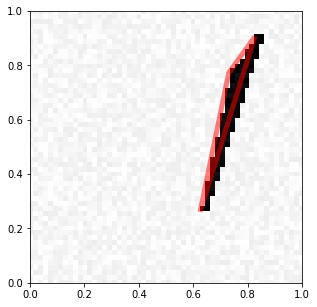

In [193]:
visualize_prediction(X_train[49], (Y_train_norm[49]*std_vec)+mean_vec)

In [194]:
[X_test, Y_test] = generate_test_set_regression()
Y_test_norm = Y_test
Y_test_norm[:,[0,2,4]] = (Y_test_norm[:,[0,2,4]] - mean_x)/std_x
Y_test_norm[:,[1,3,5]] = Y_test_norm[:,[1,3,5]] - mean_y/std_y

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [206]:
#sgd = SGD(lr=0.03, decay=1e-8, momentum=0.0,  nesterov=True) 
adam = Adam(lr=1e-3, beta_1=0.7, beta_2=0.999, epsilon=None)
modelReg.compile(loss='mean_squared_error',
                optimizer=adam)

In [207]:
modelReg.fit(X_train, Y_train,  batch_size=32, epochs=150, verbose=1) 

Epoch 1/150
1000/1000 [==============================] - 6s 6ms/step - loss: 0.8051
Epoch 2/150
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5426
Epoch 3/150
1000/1000 [==============================] - 4s 4ms/step - loss: 0.4493
Epoch 4/150
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3989
Epoch 5/150
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3454
Epoch 6/150
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3208
Epoch 7/150
1000/1000 [==============================] - 4s 4ms/step - loss: 0.2921
Epoch 8/150
1000/1000 [==============================] - 4s 4ms/step - loss: 0.2696
Epoch 9/150
1000/1000 [==============================] - 5s 5ms/step - loss: 0.2498
Epoch 10/150
1000/1000 [==============================] - 4s 4ms/step - loss: 0.2387
Epoch 11/150
1000/1000 [==============================] - 5s 5ms/step - loss: 0.2393
Epoch 12/150
1000/1000 [==============================] - 5s 5ms/step - lo

1000/1000 [==============================] - 4s 4ms/step - loss: 0.0920
Epoch 98/150
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0981
Epoch 99/150
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0970
Epoch 100/150
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0915
Epoch 101/150
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0924
Epoch 102/150
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0904
Epoch 103/150
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0896
Epoch 104/150
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0916
Epoch 105/150
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0926
Epoch 106/150
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0926
Epoch 107/150
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0902
Epoch 108/150
1000/1000 [==============================] - 4s 4ms/step

In [125]:
print(Y_train)

[[-0.53749702  0.21438578 -0.0383178  -1.44062782  1.61124432 -0.37421552]
 [-0.5653932   0.29475751  0.54908908  1.56777858  0.72177424 -0.71369399]
 [-1.3093227   1.2822423  -0.83676638 -1.66215197 -0.15763815  0.07663483]
 ..., 
 [ 0.54908908  1.56777858  0.72177424 -0.71369399 -0.5653932   0.29475751]
 [ 1.61124432 -0.37421552 -0.0383178  -1.44062782 -0.53749702  0.21438578]
 [-1.3093227   1.2822423  -0.83676638 -1.66215197 -0.15763815  0.07663483]]


[-1.68524017 -0.84696017 -1.65867681  0.66118412 -0.45625082  0.27581741]
[[-1.68524017 -0.84696017]
 [-1.65867681  0.66118412]
 [-0.45625082  0.27581741]]


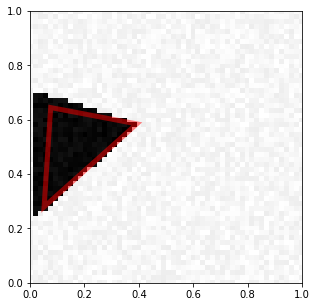

In [212]:
sample = 72

print(Y_train[sample])
print(Y_train[sample].reshape(3,2))
Y_predict = modelReg.predict(X_train[sample].reshape(1, 72, 72, 1))
visualize_prediction(X_train[sample],(Y_predict*std_vec)+mean_vec)

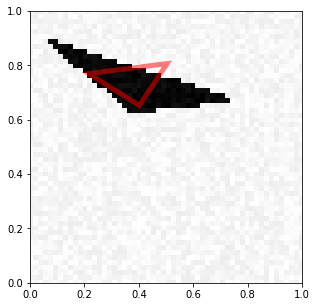